<a href="https://colab.research.google.com/github/Benja0501/Benja0501.github.io/blob/main/Sistema_cancer_de_mama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema Inteligente de Diagnóstico de Cáncer de Mama

Celda 1 – Montaje de Google Drive y configuración de entorno

In [1]:
from google.colab import drive

drive.mount('/content/drive')

# Instalación de dependencias
!pip install --quiet \
    tensorflow keras scikit-learn matplotlib seaborn pandas numpy \
    keras-tuner pyngrok fpdf scikit-image

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [2]:
# === Celda 0: instala Streamlit y dependencias ===
!pip install streamlit pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


### Celda 2 – Acceso al dataset en Google Drive

In [3]:
# El dataset está en tu Google Drive como ZIP
# Ajusta la ruta a tu archivo ZIP en Drive:
ZIP_PATH = '/content/drive/MyDrive/DATASET/ultrasound/archive.zip'
# Carpeta de destino en Colab:
TARGET_DIR = '/content/data'

# Descomprímelo si no existe ya:
import os
if not os.path.exists(TARGET_DIR):
    os.makedirs(TARGET_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{TARGET_DIR}"

# Verifica las carpetas 'BENIGN' y 'MALIGNANT'
import os
print("Clases disponibles:", os.listdir(TARGET_DIR))

Clases disponibles: ['Dataset_BUSI_with_GT']


### Celda 3 – Filtrado de clases “benigno” vs “maligno”

In [4]:
import os, shutil

# Carpeta con las clases descomprimidas
dataset_dir = '/content/data/Dataset_BUSI_with_GT'
out_dir = '/content/filtered_data'

# Filtrar solo 'benign' y 'malignant', ignorando 'normal'
for cls in ['benign', 'malignant']:
    src = os.path.join(dataset_dir, cls)
    dst = os.path.join(out_dir, cls)
    os.makedirs(dst, exist_ok=True)
    for filename in os.listdir(src):
        shutil.copy(os.path.join(src, filename), dst)

# Mostrar recuento por clase
for cls in ['benign', 'malignant']:
    print(f"{cls}:", len(os.listdir(os.path.join(out_dir, cls))))

benign: 891
malignant: 421


### cell 4 – Módulo `preprocessing.py`

In [5]:
%%writefile preprocessing.py
from skimage.io import imread
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
import numpy as np

def preprocess_image(image, target_size=(512,512)):
    """
    Redimensiona la imagen, aplica CLAHE y normaliza a [0,1].
    """
    # Convertir a float32
    img_arr = np.array(image, dtype=np.float32)
    # Redimensionar con anti_aliasing sobre floats
    img = resize(img_arr, target_size, mode='reflect', anti_aliasing=True, preserve_range=True)
    # Aplicar CLAHE
    img = equalize_adapthist(img)
    # Normalizar a [0,1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

def load_and_preprocess_image(path, target_size=(512,512)):
    """
    Lee una imagen en escala de grises, aplica preprocess_image y devuelve:
    - proc: imagen preprocesada (float32 con canal extra)
    - orig: imagen redimensionada para visualización
    """
    # Leer en gris y forzar float32
    img = imread(path, as_gray=True)
    img_arr = np.array(img, dtype=np.float32)
    # Preprocesar imagen
    proc = preprocess_image(img_arr, target_size)
    # Añadir dimensión de canal para compatibilidad con modelos
    proc = proc[..., np.newaxis]
    # Redimensionar sin anti_aliasing para visualización
    orig = resize(img_arr, target_size, mode='reflect', anti_aliasing=False, preserve_range=True)
    return proc, orig

Writing preprocessing.py


In [6]:
# Recarga el módulo sin reiniciar el runtime
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import load_and_preprocess_image

# Selecciona un ejemplo automático de 'benign'
import os
first_file = os.listdir('/content/filtered_data/benign')[0]
ejemplo = f'/content/filtered_data/benign/{first_file}'
proc, orig = load_and_preprocess_image(ejemplo)

print('Usando ejemplo:', ejemplo)
print('proc:', proc.shape, 'orig:', orig.shape)

Usando ejemplo: /content/filtered_data/benign/benign (327).png
proc: (512, 512, 1) orig: (512, 512)


### Celda 5 – Módulo model_utils.py

In [19]:
%%writefile model_utils.py
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import numpy as np
from tensorflow.keras.applications import (
    ResNet50, InceptionV3, DenseNet121
)

def load_models(input_shape_gray=(512,512,1), input_shape_rgb=(512,512,3)):
    models = {}

    # ---- CustomCNN en gris ----
    inp = Input(shape=input_shape_gray)
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D((2,2))(x); x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x); x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x); x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    custom = Model(inputs=inp, outputs=out)
    custom.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    models['CustomCNN'] = custom

    # ---- Helper para pretrained RGB ----
    def _build_pretrained(base_cls, name):
        inp_rgb = Input(shape=input_shape_rgb)
        base = base_cls(weights='imagenet', include_top=False, input_tensor=inp_rgb)
        base.trainable = False
        y = GlobalAveragePooling2D()(base.output)
        y = Dense(256, activation='relu')(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)
        m = Model(inputs=inp_rgb, outputs=y)
        m.compile(
            optimizer=Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
        )
        models[name] = m

    # ---- Construcción de los 3 pretrained ----
    _build_pretrained(ResNet50,    'ResNet50')
    _build_pretrained(InceptionV3, 'InceptionV3')
    _build_pretrained(DenseNet121, 'DenseNet121')
    return models

# Funciones de inferencia
def predict_image(model, img_preprocessed):
    """
    Para CustomCNN (input: 512x512x1, valores [0,1])
    """
    # Asegura (512,512,1) → (1,512,512,1)
    if img_preprocessed.ndim == 2:  # Si es (512,512)
        x = img_preprocessed[..., np.newaxis]
    elif img_preprocessed.shape[-1] != 1:
        x = img_preprocessed[..., np.newaxis]
    else:
        x = img_preprocessed
    x = x[np.newaxis, ...]
    y_prob = float(model.predict(x)[0, 0])
    pred = int(y_prob > 0.5)
    # Saliency map dummy (puedes reemplazar por uno real)
    saliency = np.zeros(img_preprocessed.shape[:2])
    return pred, y_prob, saliency

def predict_image_rgb(model, img_preprocessed):
    """
    Para modelos RGB (input: 512x512x3, valores [0,1])
    """
    if img_preprocessed.shape[-1] == 1:
        # Si tiene 1 canal, repite para hacer 3 canales
        x = np.repeat(img_preprocessed, 3, axis=-1)
    else:
        x = img_preprocessed
    x = x[np.newaxis, ...]
    y_prob = float(model.predict(x)[0, 0])
    pred = int(y_prob > 0.5)
    saliency = np.zeros(img_preprocessed.shape[:2])
    return pred, y_prob, saliency

def generate_saliency_map(model, img_input):
    img_tensor = tf.convert_to_tensor(np.expand_dims(img_input, 0), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        pred = model(img_tensor)
    grads = tape.gradient(pred, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    saliency = (saliency - tf.reduce_min(saliency)) / (
        tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8
    )
    return saliency.numpy()

if __name__ == '__main__':
    ms = load_models()
    for name, m in ms.items():
        m.save(f'/content/models/{name}.h5')


Overwriting model_utils.py


In [8]:
# Recarga el módulo sin reiniciar el runtime
import importlib
import model_utils
importlib.reload(model_utils)
from model_utils import load_models, generate_saliency_map

# Carga los modelos
models_dict = load_models()
print("Modelos disponibles:", list(models_dict.keys()))

# Prueba Grad-CAM con el CustomCNN sobre el ejemplo preprocesado
model = models_dict['CustomCNN']
sal = generate_saliency_map(model, proc)
print('Saliency map shape:', sal.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelos disponibles: ['CustomCNN', 'ResNet50', 'InceptionV3', 'DenseNet121']
Saliency map shape: (512, 512)


### Celda 6 – Generadores con ImageDataGenerator

In [9]:
# --- Celda 6 corregida ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Tamaño de entrada de los modelos
IMG_SIZE = (512, 512)
BATCH_SIZE = 4

# Habilitar growth en GPU si es posible
try:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.set_memory_growth(gpu, True)
except Exception as e:
    print('No se pudo configurar memory growth:', e)

# Generadores RGB para los pre-entrenados
datagen_rgb = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen_rgb.flow_from_directory(
    '/content/filtered_data',
    target_size=IMG_SIZE,
    color_mode='rgb',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=42
)
val_gen = datagen_rgb.flow_from_directory(
    '/content/filtered_data',
    target_size=IMG_SIZE,
    color_mode='rgb',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    seed=42
)

# Generadores grayscale para CustomCNN
datagen_gray = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen_gray = datagen_gray.flow_from_directory(
    '/content/filtered_data',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=42
)
val_gen_gray = datagen_gray.flow_from_directory(
    '/content/filtered_data',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    seed=42
)

print('Train RGB samples:', train_gen.samples)
print('Validation RGB samples:', val_gen.samples)
print('Train gray samples:', train_gen_gray.samples)
print('Validation gray samples:', val_gen_gray.samples)


No se pudo configurar memory growth: module 'tensorflow._api.v2.config' has no attribute 'set_memory_growth'
Found 1050 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Train RGB samples: 1050
Validation RGB samples: 262
Train gray samples: 1050
Validation gray samples: 262


### Celda 7 – Entrenamiento de los modelos con callbacks

In [10]:
import os, gc
from model_utils import load_models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

EPOCHS = 10
# Cargar y seleccionar 4 modelos para no quedarnos sin RAM
all_models = load_models()
models_to_train = ['ResNet50','InceptionV3','DenseNet121','CustomCNN']
models_dict = {n: all_models[n] for n in models_to_train}

os.makedirs('/content/models', exist_ok=True)
history = {}

for name, mdl in models_dict.items():
    print(f"▶️ Entrenando {name}")
    ckpt = f"/content/models/{name}.h5"
    cp_cb = ModelCheckpoint(ckpt, monitor='val_accuracy', save_best_only=True, verbose=1)
    es_cb = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

    # Selección de generador
    tgen, vgen = (train_gen_gray, val_gen_gray) if name=='CustomCNN' else (train_gen, val_gen)
    history[name] = mdl.fit(tgen, validation_data=vgen,
                             epochs=EPOCHS, callbacks=[cp_cb, es_cb])

    # Limpiar memoria
    del mdl
    K.clear_session()
    gc.collect()

▶️ Entrenando ResNet50
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5643 - auc: 0.5145 - loss: 0.9395 - precision: 0.2802 - recall: 0.2743
Epoch 1: val_accuracy improved from -inf to 0.79771, saving model to /content/models/ResNet50.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.5646 - auc: 0.5147 - loss: 0.9385 - precision: 0.2806 - recall: 0.2743 - val_accuracy: 0.7977 - val_auc: 0.6878 - val_loss: 0.5665 - val_precision: 0.9429 - val_recall: 0.3929
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6788 - auc: 0.5984 - loss: 0.6428 - precision: 0.5256 - recall: 0.3229
Epoch 2: val_accuracy did not improve from 0.79771
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.6789 - auc: 0.5985 - loss: 0.6427 - precision: 0.5258 - recall: 0.3228 - val_accuracy: 0.7328 - val_auc: 0.7652 - val_loss: 0.5533 - val_precision: 1.0000 - val_recall: 0.1667
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7540 - auc: 0.7173 - loss: 0.5395 - precision: 0.7049 - recall: 0.3446
Epoch 3: val_accuracy did not improve from 0.79771
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7540 - auc: 0.7172 - loss: 0.5395 - precision: 0.7049 - recall: 0.3446 - val_accuracy: 0.7366 - va

263/263 ━━━━━━━━━━━━━━━━━━━━ 67s 184ms/step - accuracy: 0.7055 - auc: 0.6646 - loss: 0.5858 - precision: 0.5944 - recall: 0.2059 - val_accuracy: 0.8168 - val_auc: 0.8582 - val_loss: 0.4501 - val_precision: 0.8750 - val_recall: 0.5000
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8197 - auc: 0.9083 - loss: 0.3840 - precision: 0.8298 - recall: 0.5391
Epoch 2: val_accuracy improved from 0.81679 to 0.82061, saving model to /content/models/InceptionV3.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8197 - auc: 0.9084 - loss: 0.3840 - precision: 0.8299 - recall: 0.5393 - val_accuracy: 0.8206 - val_auc: 0.8746 - val_loss: 0.4081 - val_precision: 0.9111 - val_recall: 0.4881
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8668 - auc: 0.9397 - loss: 0.3204 - precision: 0.8341 - recall: 0.7518
Epoch 3: val_accuracy improved from 0.82061 to 0.83969, saving model to /content/models/InceptionV3.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8668 - auc: 0.9397 - loss: 0.3204 - precision: 0.8342 - recall: 0.7517 - val_accuracy: 0.8397 - val_auc: 0.8925 - val_loss: 0.3824 - val_precision: 0.9773 - val_recall: 0.5119
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8781 - auc: 0.9444 - loss: 0.3017 - precision: 0.8788 - recall: 0.7669
Epoch 4: val_accuracy improved from 0.83969 to 0.84733, saving model to /content/models/InceptionV3.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8782 - auc: 0.9444 - loss: 0.3016 - precision: 0.8788 - recall: 0.7669 - val_accuracy: 0.8473 - val_auc: 0.9022 - val_loss: 0.3653 - val_precision: 0.9783 - val_recall: 0.5357
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9053 - auc: 0.9571 - loss: 0.2541 - precision: 0.9157 - recall: 0.7872
Epoch 5: val_accuracy did not improve from 0.84733
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.9053 - auc: 0.9571 - loss: 0.2541 - precision: 0.9156 - recall: 0.7873 - val_accuracy: 0.8473 - val_auc: 0.9034 - val_loss: 0.3616 - val_precision: 0.9783 - val_recall: 0.5357
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9100 - auc: 0.9676 - loss: 0.2258 - precision: 0.8797 - recall: 0.8239
Epoch 6: val_accuracy did not improve from 0.84733
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9100 - auc: 0.9676 - loss: 0.2258 - precision: 0.8798 - recall: 0.8239 - val_accuracy: 0.8473 - val

263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9194 - auc: 0.9781 - loss: 0.1953 - precision: 0.9204 - recall: 0.8278 - val_accuracy: 0.8511 - val_auc: 0.9085 - val_loss: 0.3663 - val_precision: 0.9592 - val_recall: 0.5595
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9282 - auc: 0.9789 - loss: 0.1958 - precision: 0.9242 - recall: 0.8527
Epoch 8: val_accuracy did not improve from 0.85115
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.9281 - auc: 0.9789 - loss: 0.1958 - precision: 0.9242 - recall: 0.8527 - val_accuracy: 0.8473 - val_auc: 0.9136 - val_loss: 0.3652 - val_precision: 0.9400 - val_recall: 0.5595
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9125 - auc: 0.9690 - loss: 0.2056 - precision: 0.9035 - recall: 0.8131
Epoch 9: val_accuracy did not improve from 0.85115
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.9125 - auc: 0.9690 - loss: 0.2056 - precision: 0.9035 - recall: 0.8132 - val_accuracy: 0.8015 - val

263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9191 - auc: 0.9740 - loss: 0.1964 - precision: 0.9139 - recall: 0.8228 - val_accuracy: 0.8550 - val_auc: 0.9140 - val_loss: 0.3544 - val_precision: 0.9423 - val_recall: 0.5833
Restoring model weights from the end of the best epoch: 10.
▶️ Entrenando DenseNet121
Epoch 1/10
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7209 - auc: 0.6685 - loss: 0.5725 - precision: 0.6427 - recall: 0.2340
Epoch 1: val_accuracy improved from -inf to 0.82443, saving model to /content/models/DenseNet121.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 204ms/step - accuracy: 0.7212 - auc: 0.6693 - loss: 0.5720 - precision: 0.6438 - recall: 0.2349 - val_accuracy: 0.8244 - val_auc: 0.8469 - val_loss: 0.4568 - val_precision: 1.0000 - val_recall: 0.4524
Epoch 2/10
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8522 - auc: 0.9149 - loss: 0.3728 - precision: 0.8738 - recall: 0.6284
Epoch 2: val_accuracy did not improve from 0.82443
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.8523 - auc: 0.9150 - loss: 0.3726 - precision: 0.8739 - recall: 0.6284 - val_accuracy: 0.8244 - val_auc: 0.8587 - val_loss: 0.4115 - val_precision: 0.8654 - val_recall: 0.5357
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8588 - auc: 0.9297 - loss: 0.3369 - precision: 0.8508 - recall: 0.7044
Epoch 3: val_accuracy improved from 0.82443 to 0.83588, saving model to /content/models/DenseNet121.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.8588 - auc: 0.9297 - loss: 0.3368 - precision: 0.8509 - recall: 0.7044 - val_accuracy: 0.8359 - val_auc: 0.8685 - val_loss: 0.4018 - val_precision: 0.9362 - val_recall: 0.5238
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9054 - auc: 0.9556 - loss: 0.2660 - precision: 0.8980 - recall: 0.8013
Epoch 4: val_accuracy improved from 0.83588 to 0.83969, saving model to /content/models/DenseNet121.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9053 - auc: 0.9555 - loss: 0.2661 - precision: 0.8979 - recall: 0.8012 - val_accuracy: 0.8397 - val_auc: 0.8755 - val_loss: 0.3959 - val_precision: 0.9565 - val_recall: 0.5238
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9072 - auc: 0.9558 - loss: 0.2613 - precision: 0.8996 - recall: 0.8117
Epoch 5: val_accuracy did not improve from 0.83969
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.9072 - auc: 0.9558 - loss: 0.2613 - precision: 0.8996 - recall: 0.8117 - val_accuracy: 0.8397 - val_auc: 0.8806 - val_loss: 0.3819 - val_precision: 0.8750 - val_recall: 0.5833
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9115 - auc: 0.9653 - loss: 0.2286 - precision: 0.9022 - recall: 0.8142
Epoch 6: val_accuracy did not improve from 0.83969
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9115 - auc: 0.9653 - loss: 0.2286 - precision: 0.9021 - recall: 0.8142 - val_accuracy: 0.8321 - val

263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9205 - auc: 0.9707 - loss: 0.2194 - precision: 0.9028 - recall: 0.8435 - val_accuracy: 0.8435 - val_auc: 0.8847 - val_loss: 0.3838 - val_precision: 0.8644 - val_recall: 0.6071
Epoch 8/10
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9231 - auc: 0.9536 - loss: 0.2213 - precision: 0.8919 - recall: 0.8244
Epoch 8: val_accuracy did not improve from 0.84351
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9231 - auc: 0.9537 - loss: 0.2212 - precision: 0.8920 - recall: 0.8246 - val_accuracy: 0.8435 - val_auc: 0.8884 - val_loss: 0.3761 - val_precision: 0.8525 - val_recall: 0.6190
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9234 - auc: 0.9773 - loss: 0.1983 - precision: 0.8908 - recall: 0.8890
Epoch 9: val_accuracy did not improve from 0.84351
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9234 - auc: 0.9772 - loss: 0.1984 - precision: 0.8908 - recall: 0.8888 - val_accuracy: 0.8397 - val

263/263 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.6597 - auc: 0.6207 - loss: 0.6269 - precision: 0.4671 - recall: 0.3169 - val_accuracy: 0.6794 - val_auc: 0.5908 - val_loss: 0.6273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6832 - auc: 0.6592 - loss: 0.6036 - precision: 0.5566 - recall: 0.2645
Epoch 2: val_accuracy did not improve from 0.67939
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6832 - auc: 0.6592 - loss: 0.6036 - precision: 0.5565 - recall: 0.2645 - val_accuracy: 0.6794 - val_auc: 0.6437 - val_loss: 0.5984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6919 - auc: 0.7174 - loss: 0.5811 - precision: 0.6425 - recall: 0.2702
Epoch 3: val_accuracy improved from 0.67939 to 0.72901, saving model to /content/models/CustomCNN.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6919 - auc: 0.7173 - loss: 0.5811 - precision: 0.6423 - recall: 0.2701 - val_accuracy: 0.7290 - val_auc: 0.6838 - val_loss: 0.5753 - val_precision: 0.7407 - val_recall: 0.2381
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6718 - auc: 0.6666 - loss: 0.6014 - precision: 0.5280 - recall: 0.3083
Epoch 4: val_accuracy did not improve from 0.72901
263/263 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6719 - auc: 0.6667 - loss: 0.6013 - precision: 0.5282 - recall: 0.3083 - val_accuracy: 0.7099 - val_auc: 0.6914 - val_loss: 0.5895 - val_precision: 0.7857 - val_recall: 0.1310
Epoch 5/10
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7114 - auc: 0.7138 - loss: 0.5612 - precision: 0.5908 - recall: 0.2961
Epoch 5: val_accuracy did not improve from 0.72901
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7114 - auc: 0.7139 - loss: 0.5612 - precision: 0.5909 - recall: 0.2962 - val_accuracy: 0.6336 - val

In [11]:
%%writefile metrics_utils.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2
from tensorflow.keras.models import load_model

def matthews_corrcoef(cm):
    tp, fp, fn, tn = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    num = tp*tn - fp*fn
    den = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return num/den if den!=0 else 0

def mcnemar_test(y_true, y1, y2):
    b = np.sum((y1==y_true)&(y2!=y_true))
    c = np.sum((y1!=y_true)&(y2==y_true))
    if (b+c)>25:
        stat = (abs(b-c)-1)**2/(b+c)
    else:
        stat = (abs(b-c))**2/(b+c) if (b+c)>0 else 0
    p = 1 - chi2.cdf(stat, df=1)
    return stat, p

def evaluate_on_dataset(test_dir, img_size=512, batch_size=8):
    """
    Devuelve:
      - df: DataFrame con columnas y_true, <Modelo>_proba, <Modelo>_pred
      - comparisons: dict con claves "i_j" de McNemar
      - cms: lista de rutas a los PNG de cada matriz de confusión
    """
    # 1) Listar rutas y etiquetas
    paths, labels = [], []
    for cls,label in [('benign',0),('malignant',1)]:
        d = os.path.join(test_dir, cls)
        for fn in os.listdir(d):
            paths.append(os.path.join(d, fn))
            labels.append(label)
    y = np.array(labels)
    results = {'y_true': y}
    cms = []

    # 2) Cargar modelos entrenados
    models = {
        "ResNet50":   load_model(os.path.join('models','ResNet50.h5')),
        "InceptionV3":load_model(os.path.join('models','InceptionV3.h5')),
        "DenseNet121":load_model(os.path.join('models','DenseNet121.h5')),
        "CustomCNN":  load_model(os.path.join('models','CustomCNN.h5')),
    }
    names = list(models.keys())

    # 3) Para cada modelo: abrir imagen, resize, normalizar, predecir
    for name, mdl in models.items():
        print(f"▶️ Evaluando {name}")
        X = []
        for p in paths:
            img = Image.open(p)
            img = img.convert('RGB') if name!="CustomCNN" else img.convert('L')
            img = img.resize((img_size, img_size))
            arr = np.asarray(img, np.float32) / 255.0
            if name=="CustomCNN":
                arr = arr[...,None]
            X.append(arr)
        X = np.stack(X, axis=0)

        probas = mdl.predict(X, batch_size=batch_size).ravel()
        preds  = (probas>0.5).astype(int)
        results[f"{name}_proba"] = probas
        results[f"{name}_pred"]  = preds

        # generar y guardar heatmap de su matriz de confusión
        cm = confusion_matrix(y, preds)
        fig, ax = plt.subplots(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['benign','malignant'], yticklabels=['benign','malignant'])
        ax.set_title(f"CM – {name}")
        fn = f"cm_{name}.png"
        fig.savefig(fn, bbox_inches='tight')
        plt.close(fig)
        cms.append(fn)

    # 4) McNemar en cada par
    comps = {}
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            comps[f"{i}_{j}"] = mcnemar_test(
                y,
                results[f"{names[i]}_pred"],
                results[f"{names[j]}_pred"]
            )

    # 5) construir DataFrame y lista de métricas para el reporte
    df = pd.DataFrame(results)
    metrics_list = []
    for name in names:
        cm = confusion_matrix(y, df[f"{name}_pred"])
        rpt = classification_report(y, df[f"{name}_pred"],
                                    target_names=['benign','malignant'],
                                    output_dict=True)
        metrics_list.append({
            'model': name,
            'accuracy': rpt['accuracy'],
            'sensitivity': rpt['malignant']['recall'],
            'specificity': rpt['benign']['recall'],
            'f1': rpt['malignant']['f1-score'],
            'mcc': matthews_corrcoef(cm)
        })

    return df, comps, cms, metrics_list


Writing metrics_utils.py


In [17]:
%%writefile report_utils.py
from fpdf import FPDF
import time
import os
import matplotlib.pyplot as plt
import numpy as np

# Para un solo modelo con mapa de saliencia (opcional, aún útil para otros flujos)
def generate_pdf_report(image_original, heatmap, diagnosis, confidence, model_name):
    combined_path = "combined_temp.png"
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(image_original, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')
    axes[1].imshow(image_original, cmap='gray')
    axes[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[1].set_title("Mapa de Saliencia")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(combined_path, dpi=300)
    plt.close()

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="Reporte de Diagnóstico Mamario", ln=1, align='C')
    pdf.ln(5)

    pdf.cell(200, 10, txt=f"Modelo utilizado: {model_name}", ln=1)
    pdf.cell(200, 10, txt=f"Fecha: {time.strftime('%Y-%m-%d %H:%M:%S')}", ln=1)
    pdf.cell(200, 10, txt=f"Diagnóstico: {'Positivo para Cáncer' if diagnosis else 'Negativo para Cáncer'}", ln=1)
    pdf.cell(200, 10, txt=f"Confianza: {confidence*100:.2f}%", ln=1)
    pdf.ln(10)

    pdf.cell(200, 10, txt="Imágenes de Diagnóstico:", ln=1)
    pdf.image(combined_path, w=180)

    pdf_path = "diagnostico_mama.pdf"
    pdf.output(pdf_path)

    os.remove(combined_path)
    return pdf_path

# NUEVO: Para PDF consolidado de inferencia múltiple de modelos
def generate_multi_model_report(image_original, results, output_path="diagnostico_mama_multimodelo.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", 'B', 18)
    pdf.cell(0, 12, "Diagnóstico de Cáncer de Mama", ln=1, align='C')
    pdf.set_font("Arial", '', 13)
    pdf.cell(0, 10, "Reporte comparativo de modelos de IA", ln=1, align='C')
    pdf.ln(6)

    # Imagen original
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 8, "Imagen de entrada:", ln=1)
    img_path = "_temp_input.png"
    if isinstance(image_original, np.ndarray):
        plt.imsave(img_path, image_original, cmap='gray')
    else:
        image_original.save(img_path)
    pdf.image(img_path, x=40, w=120)
    os.remove(img_path)
    pdf.ln(3)

    # Resultados por modelo
    for res in results:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 8, f"Modelo: {res['model']}", ln=1)
        pdf.set_font("Arial", '', 11)
        pdf.cell(0, 8, f"Diagnóstico: {'Positivo' if res['prediction'] else 'Negativo'}", ln=1)
        pdf.cell(0, 8, f"Probabilidad: {res['probability']:.2%}", ln=1)
        pdf.ln(1)
        # Saliency map
        saliency_path = f"_temp_sal_{res['model']}.png"
        plt.imsave(saliency_path, res['saliency'], cmap='jet')
        pdf.image(saliency_path, x=60, w=90)
        os.remove(saliency_path)
        pdf.ln(5)

    pdf.output(output_path)
    return output_path

# PDF comparativo con métricas, matrices, McNemar
def generate_comparison_report(metrics_list, model_names, comparisons, confusion_images, output_path='comparativo_mama.pdf'):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, txt="Reporte Comparativo de Modelos", ln=1, align='C')
    pdf.cell(200, 10, txt=f"Fecha: {time.strftime('%Y-%m-%d %H:%M:%S')}", ln=1)
    pdf.ln(5)

    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Métricas Generales", ln=1)
    pdf.set_font("Arial", 'B', 10)

    col_width = 32
    headers = ["Modelo", "Precisión", "Sensibilidad", "Especificidad", "F1-Score", "MCC"]
    for header in headers:
        pdf.cell(col_width, 8, header, border=1, align='C')
    pdf.ln()

    pdf.set_font("Arial", size=10)
    for m in metrics_list:
        pdf.cell(col_width, 8, m['model'], border=1)
        pdf.cell(col_width, 8, f"{m['accuracy']:.3f}", border=1, align='C')
        pdf.cell(col_width, 8, f"{m['sensitivity']:.3f}", border=1, align='C')
        pdf.cell(col_width, 8, f"{m['specificity']:.3f}", border=1, align='C')
        pdf.cell(col_width, 8, f"{m['f1']:.3f}", border=1, align='C')
        pdf.cell(col_width, 8, f"{m['mcc']:.3f}", border=1, align='C')
        pdf.ln()
    pdf.ln(5)

    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Comparaciones Estadísticas (McNemar)", ln=1)
    pdf.set_font("Arial", size=10)
    for key, (stat, p) in comparisons.items():
        i, j = map(int, key.split('_'))
        pdf.multi_cell(0, 8,
            f"Comparación {model_names[i]} vs {model_names[j]}:\n"
            f"Estadístico de McNemar = {stat:.4f}, p-value = {p:.4f}\n"
        )

    pdf.add_page()
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, "Matrices de Confusión", ln=1)
    pdf.set_font("Arial", size=10)
    x_positions = [10, 110]
    y = pdf.get_y()
    for idx, img_path in enumerate(confusion_images):
        col = idx % 2
        if idx and col == 0:
            y += 80
        pdf.set_xy(x_positions[col], y)
        pdf.cell(90, 10, txt=f"Matriz de Confusión - {model_names[idx]}", ln=2)
        pdf.set_x(x_positions[col])
        pdf.image(img_path, x=x_positions[col], y=pdf.get_y(), w=80)

    pdf.output(output_path)
    return output_path

Overwriting report_utils.py


### Celda 8 – Curvas ROC, métricas y matrices de confusión


▶️ Evaluando ResNet50


Found 1312 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step

▶️ Evaluando InceptionV3


Found 1312 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step

▶️ Evaluando DenseNet121


Found 1312 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step



▶️ Evaluando CustomCNN
Found 1312 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


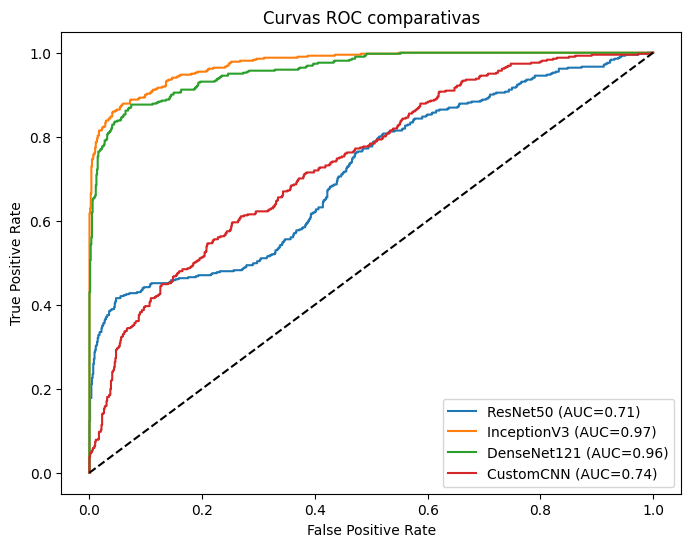


--- Reporte para ResNet50 ---
              precision    recall  f1-score   support

      benign       0.77      0.96      0.85       891
   malignant       0.82      0.39      0.53       421

    accuracy                           0.78      1312
   macro avg       0.79      0.67      0.69      1312
weighted avg       0.78      0.78      0.75      1312

MCC: 0.451


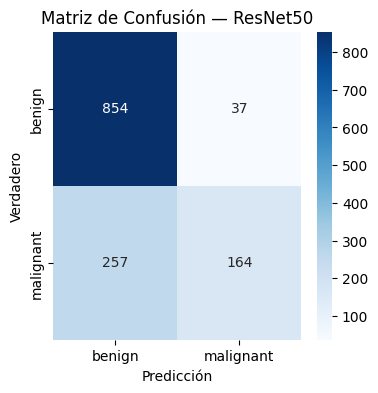


--- Reporte para InceptionV3 ---
              precision    recall  f1-score   support

      benign       0.92      0.98      0.95       891
   malignant       0.96      0.81      0.88       421

    accuracy                           0.93      1312
   macro avg       0.94      0.90      0.91      1312
weighted avg       0.93      0.93      0.93      1312

MCC: 0.834


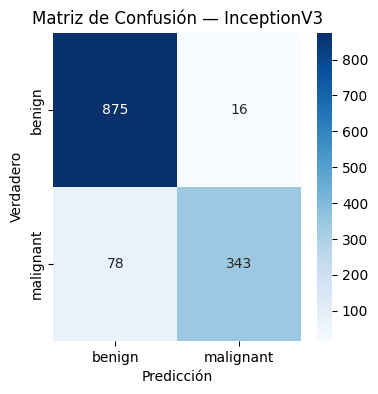


--- Reporte para DenseNet121 ---
              precision    recall  f1-score   support

      benign       0.92      0.95      0.94       891
   malignant       0.89      0.84      0.86       421

    accuracy                           0.91      1312
   macro avg       0.91      0.89      0.90      1312
weighted avg       0.91      0.91      0.91      1312

MCC: 0.800


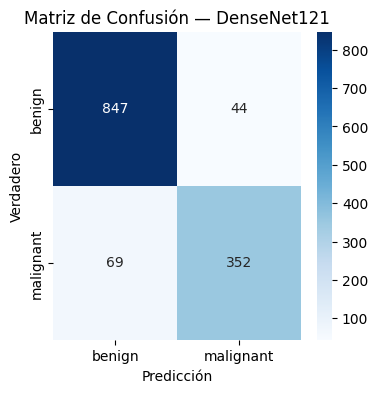


--- Reporte para CustomCNN ---
              precision    recall  f1-score   support

      benign       0.75      0.94      0.83       891
   malignant       0.72      0.33      0.45       421

    accuracy                           0.74      1312
   macro avg       0.74      0.63      0.64      1312
weighted avg       0.74      0.74      0.71      1312

MCC: 0.355


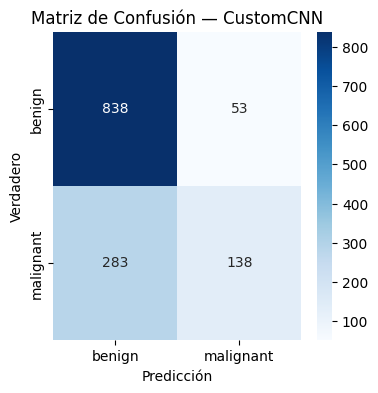


=== Pruebas de McNemar ===
ResNet50 vs InceptionV3: estadístico=162.2992, p-value=0.0000
ResNet50 vs DenseNet121: estadístico=118.6813, p-value=0.0000
ResNet50 vs CustomCNN: estadístico=10.0060, p-value=0.0016
InceptionV3 vs DenseNet121: estadístico=4.2078, p-value=0.0402
InceptionV3 vs CustomCNN: estadístico=208.9245, p-value=0.0000
DenseNet121 vs CustomCNN: estadístico=159.4951, p-value=0.0000


In [13]:
# === Celda 8: Evaluación eficiente por modelo ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    confusion_matrix
)
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Parámetros
TEST_DIR   = '/content/filtered_data'
IMG_SIZE   = 512
BATCH_SIZE = 4
MODEL_PATHS = {
    'ResNet50':    '/content/models/ResNet50.h5',
    'InceptionV3': '/content/models/InceptionV3.h5',
    'DenseNet121': '/content/models/DenseNet121.h5',
    'CustomCNN':   '/content/models/CustomCNN.h5'
}

# Función helper para predecir por batch desde disco sin cargar todo en memoria
def evaluate_with_generator(model, test_dir, img_size=512, batch_size=4, color_mode='rgb'):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    gen = ImageDataGenerator(rescale=1./255)
    flow = gen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        classes=['benign','malignant'],
        class_mode='binary',
        color_mode=color_mode,
        batch_size=batch_size,
        shuffle=False
    )
    probas = model.predict(flow, verbose=1)
    preds  = (probas.ravel() > 0.5).astype(int)
    return flow.classes, probas.ravel(), preds

# Diccionarios para guardar resultados
probas_dict = {}
preds_dict  = {}
cm_dict     = {}
roc_dict    = {}
y_true      = None

# 1) Evaluar cada modelo por separado
for name, path in MODEL_PATHS.items():
    print(f"\n▶️ Evaluando {name}")
    model = load_model(path)
    mode = 'grayscale' if name=='CustomCNN' else 'rgb'
    y_true, probas, preds = evaluate_with_generator(model, TEST_DIR,
                                                    img_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    color_mode=mode)
    probas_dict[name] = probas
    preds_dict[name]  = preds
    cm = confusion_matrix(y_true, preds)
    cm_dict[name]     = cm
    fpr, tpr, _       = roc_curve(y_true, probas)
    roc_dict[name]    = (fpr, tpr)
    # liberar memoria
    del model
    K.clear_session()

# 2) Curvas ROC comparativas
plt.figure(figsize=(8,6))
for name, (fpr, tpr) in roc_dict.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("Curvas ROC comparativas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3) Classification report, MCC y matrices de confusión
from sklearn.metrics import matthews_corrcoef
for name in MODEL_PATHS:
    print(f"\n--- Reporte para {name} ---")
    y_pred = preds_dict[name]
    print(classification_report(y_true, y_pred, target_names=['benign','malignant']))
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.3f}")
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_dict[name], annot=True, fmt='d', cmap='Blues',
                xticklabels=['benign','malignant'],
                yticklabels=['benign','malignant'])
    plt.title(f"Matriz de Confusión — {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.show()

# 4) Pruebas de McNemar entre todos los pares
from metrics_utils import mcnemar_test
print("\n=== Pruebas de McNemar ===")
model_names = list(MODEL_PATHS.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        stat, p = mcnemar_test(
            y_true,
            preds_dict[model_names[i]],
            preds_dict[model_names[j]]
        )
        print(f"{model_names[i]} vs {model_names[j]}: estadístico={stat:.4f}, p-value={p:.4f}")



### Celda 9 – Comparación estadística e informe PDF

In [14]:
# === Celda 9: Evaluación con generadores por canal ===
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

from metrics_utils import matthews_corrcoef, mcnemar_test
from report_utils  import generate_comparison_report

# Parámetros
TEST_DIR    = '/content/filtered_data'   # carpetas benign/ y malignant/
IMG_SIZE    = (512, 512)
BATCH_SIZE  = 4
MODEL_PATHS = {
    'ResNet50'   : '/content/models/ResNet50.h5',
    'InceptionV3': '/content/models/InceptionV3.h5',
    'DenseNet121': '/content/models/DenseNet121.h5',
    'CustomCNN'  : '/content/models/CustomCNN.h5'
}

# 1) Definimos dos validadores: uno RGB y uno grayscale
datagen = ImageDataGenerator(rescale=1./255)
val_gen_rgb = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)
val_gen_gray = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    classes=['benign','malignant'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# extraemos y guardamos la etiqueta verdadera
y_true = val_gen_rgb.classes

metrics_list = []
all_preds    = []
cm_paths     = []

# 2) Iteramos por cada modelo
for name, model_path in MODEL_PATHS.items():
    print(f"\n▶️ Evaluando {name}")
    model = tf.keras.models.load_model(model_path, compile=False)

    # 2a) Elegimos generador según el modelo
    gen = val_gen_gray if name == 'CustomCNN' else val_gen_rgb

    # 2b) Predecimos en lote
    y_prob = model.predict(gen, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    all_preds.append(y_pred)

    # 2c) Cálculo de métricas
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(
        y_true, y_pred,
        target_names=['benign','malignant'],
        output_dict=True
    )
    metrics_list.append({
        'model'      : name,
        'accuracy'   : report['accuracy'],
        'sensitivity': report['malignant']['recall'],
        'specificity': report['benign']['recall'],
        'f1'         : report['malignant']['f1-score'],
        'mcc'        : matthews_corrcoef(cm)
    })

    # 2d) Guardamos la matriz de confusión como PNG
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['benign','malignant'],
                yticklabels=['benign','malignant'])
    plt.title(f'Matriz de Confusión – {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    cm_path = f'cm_{name}.png'
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close()
    cm_paths.append(cm_path)

    # 2e) Liberamos el modelo de la sesión
    tf.keras.backend.clear_session()

# 3) Pruebas de McNemar entre pares
comparisons = {}
names = list(MODEL_PATHS.keys())
for (i,_), (j,_) in combinations(enumerate(names), 2):
    stat, pval = mcnemar_test(y_true, all_preds[i], all_preds[j])
    comparisons[f'{i}_{j}'] = (stat, pval)

# 4) Generar PDF comparativo
pdf_path = generate_comparison_report(
    metrics_list     = metrics_list,
    model_names      = names,
    comparisons      = comparisons,
    confusion_images = cm_paths,
    output_path      = 'comparativo_mama.pdf'
)
print(f"\n✅ Reporte comparativo generado en: {pdf_path}")


Found 1312 images belonging to 2 classes.
Found 1312 images belonging to 2 classes.

▶️ Evaluando ResNet50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



▶️ Evaluando InceptionV3

▶️ Evaluando DenseNet121

▶️ Evaluando CustomCNN


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



✅ Reporte comparativo generado en: comparativo_mama.pdf


### aplicacion en streamlit

In [4]:
%%writefile app.py
import streamlit as st
import os
import numpy as np
import matplotlib.pyplot as plt

from model_utils import load_models, predict_image, predict_image_rgb, generate_saliency_map
from preprocessing import load_and_preprocess_image
from report_utils import generate_multi_model_report  # Asegúrate que existe esta función

st.set_page_config(page_title="Diagnóstico Cáncer de Mama", layout="wide")

MODEL_PATHS = {
    "CustomCNN":   "/content/models/CustomCNN.h5",
    "DenseNet121": "/content/models/DenseNet121.h5",
    "InceptionV3": "/content/models/InceptionV3.h5",
    "ResNet50":    "/content/models/ResNet50.h5",
}

@st.cache_resource
def load_model_dict(selected_names):
    from tensorflow.keras.models import load_model
    ret = {}
    for name in selected_names:
        ret[name] = load_model(MODEL_PATHS[name], compile=False)
    return ret

st.title("🩺 Sistema de Diagnóstico de Cáncer de Mama")

# --- Paso 1: Selección de modelos ---
st.sidebar.header("Paso 1: Elige modelos")
all_names = list(MODEL_PATHS.keys())
sel_models = st.sidebar.multiselect(
    "Modelos a usar para inferencia",
    all_names,
    default=["DenseNet121"]
)

# --- Paso 2: Carga de imagen ---
st.sidebar.header("Paso 2: Carga imagen")
uploaded = st.sidebar.file_uploader("PNG de ultrasonido", type="png")
if not uploaded:
    st.info("Por favor sube una imagen PNG.")
    st.stop()

# --- Preprocesado ---
img_preprocessed, img_original = load_and_preprocess_image(uploaded)
# Si la imagen no está en [0,1], normalízala aquí:
if img_preprocessed.max() > 1.0:
    img_preprocessed = img_preprocessed / 255.0

st.subheader("Imagen Original y Preprocesada")
col1, col2 = st.columns(2)
with col1:
    st.image(img_original, caption="Original 512×512", use_column_width=True)
with col2:
    st.image(img_preprocessed, caption="Preprocesada 512×512", use_column_width=True)

models = load_model_dict(sel_models)

# --- Inferencia correcta según modelo ---
results = []
for name, mdl in models.items():
    if name == "CustomCNN":
        x = img_preprocessed
        if x.ndim == 2:              # (512,512) → (512,512,1)
            x = x[..., None]
    else:
        x = img_preprocessed
        if x.ndim == 2:              # (512,512) → (512,512,3)
            x = np.stack([x]*3, axis=-1)
        elif x.shape[-1] == 1:       # (512,512,1) → (512,512,3)
            x = np.repeat(x, 3, axis=-1)
        # ahora x.shape == (512,512,3)
    y_prob = float(mdl.predict(x[np.newaxis, ...])[0,0])
    y_pred = int(y_prob > 0.5)
    confidence = (y_prob if y_pred else 1 - y_prob) * 100
    saliency = generate_saliency_map(mdl, x)
    results.append({
        "model": name,
        "prediction": y_pred,
        "probability": y_prob,
        "confidence": confidence,
        "saliency": saliency
    })

# --- Mostrar resultados ---
st.subheader("Resultados por modelo")
for res in results:
    st.markdown(f"### {res['model']}")
    c1, c2, c3 = st.columns([1,1,1])
    with c1:
        st.metric("Diagnóstico", "Maligno" if res["prediction"] else "Benigno")
    with c2:
        st.metric("Confianza", f"{res['confidence']:.2f}%")
    with c3:
        st.metric("Probabilidad de malignidad", f"{res['probability']:.2%}")
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(img_original, cmap='gray')
    ax.imshow(res["saliency"], cmap='jet', alpha=0.5)
    ax.axis('off')
    st.pyplot(fig)

# --- Descargar reporte PDF multi-modelo ---
if st.button("📄 Descargar reporte PDF consolidado"):
    pdf_path = generate_multi_model_report(
        image_original=img_original,
        results=results,
        output_path="diagnostico_mama_multimodelo.pdf"
    )
    with open(pdf_path, "rb") as f:
        st.download_button(
            label="📥 Descargar PDF",
            data=f,
            file_name="diagnostico_mama_multimodelo.pdf",
            mime="application/pdf"
        )


Overwriting app.py


In [5]:
!pip install pyngrok

from pyngrok import ngrok, conf
conf.get_default().auth_token = "2zrmyWJvn4NqAIU37xGlUdrzN9i_6mXN47us3RSGewJN1k8js"

# abre el túnel HTTP al puerto 8501 (Streamlit)
public_url = ngrok.connect(8501)
print("🌐 App disponible en:", public_url)
!streamlit run app.py


🌐 App disponible en: NgrokTunnel: "https://e9a2eabbe885.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.33.0:8501

2025-07-14 17:54:00.957153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752515640.980690   19596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752515640.987850   19596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 17:54:01.011789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance

In [6]:
%cd /content


/content


In [7]:
!git config --global user.name "Bemja0501"
!git config --global user.email "g2333300121@unitru.edu.pe"


In [8]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [10]:
!pwd
!ls -l


/content
total 468
-rw-r--r-- 1 root root   3906 Jul 14 17:53 app.py
-rw-r--r-- 1 root root  23349 Jul 14 17:04 cm_CustomCNN.png
-rw-r--r-- 1 root root  23079 Jul 14 17:04 cm_DenseNet121.png
-rw-r--r-- 1 root root  23125 Jul 14 17:03 cm_InceptionV3.png
-rw-r--r-- 1 root root  23002 Jul 14 17:02 cm_ResNet50.png
-rw-r--r-- 1 root root  86196 Jul 14 17:04 comparativo_mama.pdf
drwxr-xr-x 3 root root   4096 Jul 14 16:48 data
-rw-r--r-- 1 root root 241462 Jul 14 17:56 diagnostico_mama_multimodelo.pdf
drwx------ 5 root root   4096 Jul 14 16:48 drive
drwxr-xr-x 4 root root   4096 Jul 14 16:48 filtered_data
-rw-r--r-- 1 root root   3961 Jul 14 17:00 metrics_utils.py
drwxr-xr-x 2 root root   4096 Jul 14 16:59 models
-rw-r--r-- 1 root root   3988 Jul 14 17:38 model_utils.py
-rw-r--r-- 1 root root   1377 Jul 14 16:48 preprocessing.py
drwxr-xr-x 2 root root   4096 Jul 14 17:40 __pycache__
-rw-r--r-- 1 root root   5178 Jul 14 17:19 report_utils.py
drwxr-xr-x 1 root root   4096 Jul 11 18:44 sample_da

In [11]:
!git config --global user.email "g2333300121@unitru.edu.pe"
!git config --global user.name "Benja0501"


In [12]:
%cd /content
!git init
!git add .
!git commit -m "Primer commit del diagnóstico de cáncer de mama"


/content
Reinitialized existing Git repository in /content/.git/
[master (root-commit) 112ee1b] Primer commit del diagnóstico de cáncer de mama
 2932 files changed, 51539 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.07.11/18.43.34.385504.log
 create mode 100644 .config/logs/2025.07.11/18.43.55.263379.log
 create mode 100644 .config/logs/2025.07.11/18.44.03.438362.log
 create mode 100644 .config/logs/2025.07.11/18.44.04.646162.log
 create mode 100644 .config/logs/2025.07.11/18.44.13.055961.log
 create mode 100644 .co

In [16]:
!git remote add origin https://github.com/Benja0501/Sistema_cancer_de_mama.git


error: remote origin already exists.


In [17]:
!git branch -M main
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address
